In [1]:
import arviz as az
import pystan, pickle
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

a = 0.5

# Load Data

In [2]:
roi = "Italy"

[29 '2/20/20' 3 0 0.0 0 0 0 0]


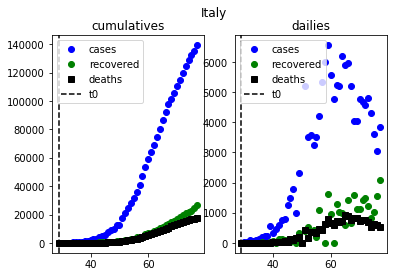

In [3]:


DF = pd.read_csv("../data/covid_timeseries_"+roi+".csv")

# pop = {}
# pop['Italy'] = 60500000
# pop['United Kingdom'] = 64400000
# pop['France'] = 66990000
# pop['Netherlands'] = 17000000

mitigate = {}
mitigate['Italy'] = '03/9/20' #approximate date
mitigate['Netherlands'] = '03/12/20' #approximate date
mitigate['US_NY'] = '03/20/20'
mitigate['UnitedKingdom'] = '3/23/20'


# t0 := where to start time series, index space
t0 = np.where(DF["new_cases"].values>=10)[0][0] - 1 #Stan starts one day back from this 
print(DF.iloc[t0].values)
# tm := start of mitigation, index space
tm = t0 + 10 #np.where(mitigate[roi]==DF['dates2'])[0][0]


#plot the data with important time stamps (t0, tm)
plt.subplot(1,2,1)
plt.title('cumulatives')
plt.plot(DF["cum_cases"][t0:],'bo', label="cases")
plt.plot(DF["cum_recover"][t0:],'go',label="recovered")
plt.plot(DF["cum_deaths"][t0:],'ks',label="deaths")

plt.axvline(t0,color='k', linestyle="dashed", label='t0')
# plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.legend()


plt.subplot(1,2,2)
plt.title('dailies')
plt.plot(DF["new_cases"][t0:],'bo', label="cases")
plt.plot(DF["new_recover"][t0:],'go',label="recovered")
plt.plot(DF["new_deaths"][t0:],'ks',label="deaths")
plt.axvline(t0,color='k', linestyle="dashed", label='t0')
# plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.suptitle(roi)
plt.legend()


# print("t0 index assumed to be: day "+str(t0))
# print("t0 date: "+DF['dates2'][t0])
# print("tm index assumed to be: day "+str(tm))
# print("mitigation date: "+DF['dates2'][tm])



In [4]:
fit = pickle.load(open("./fits/model_fit"+roi+".pkl", 'rb'))
print(fit)

{'model': <pystan.model.StanModel object at 0x134c33cd0>, 'fit': 
For the full summary use 'print(fit)'

Inference for Stan model: anon_model_39dfb0158a05fc823b35e926eb435920.
1 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    3.88    0.07   0.56   1.32   3.95   3.96   3.97   4.13     69   1.02
theta[2]    0.26    0.03   0.24    0.2   0.21   0.21   0.22   0.52     54   1.04
theta[3]    0.03  1.4e-3   0.01 5.0e-3   0.03   0.03   0.03   0.04     62    1.0
theta[4]    0.03  4.4e-4 1.2e-3   0.03   0.03   0.03   0.03   0.04      8   1.17
theta[5]  2.5e-3  7.3e-5 2.1e-4 2.4e-3 2.4e-3 2.4e-3 2.4e-3 3.3e-3      8   1.15
theta[6]     0.1    0.02   0.06   0.09   0.09   0.09   0.09   0.28     13   1.09
theta[7]    0.33  8.9e-5 3.1e-4   0.33   0.33   0.33   0.33   0.33     13    1.0
theta[8]  1703.7    0.22   0.79 1700.8 1703.7 1703.8 1704.

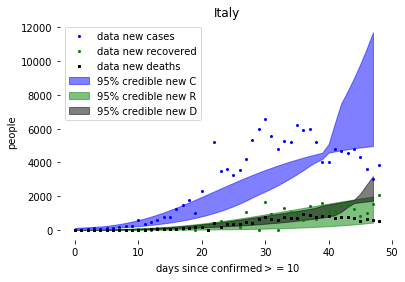

In [5]:
plt.plot(DF["new_cases"][t0:].values,'bo',ms=2, label="data new cases")
plt.plot(DF["new_recover"][t0:].values,'go',ms=2,label="data new recovered")
plt.plot(DF["new_deaths"][t0:].values,'ks',ms=2,label="data new deaths")


x = np.shape(fit['fit']['u'])[1]
newC_lb = []
newC_ub = []
newR_lb = []
newR_ub = []
newD_lb = []
newD_ub = []
for i in range(x):
    newC_lb.append(np.percentile(fit['fit']['lambda'][:,i,0],2.5))
    newC_ub.append(np.percentile(fit['fit']['lambda'][:,i,0],97.5))
    newR_lb.append(np.percentile(fit['fit']['lambda'][:,i,1],2.5))
    newR_ub.append(np.percentile(fit['fit']['lambda'][:,i,1],97.5))
    newD_lb.append(np.percentile(fit['fit']['lambda'][:,i,2],2.5))
    newD_ub.append(np.percentile(fit['fit']['lambda'][:,i,2],97.5))
    
plt.fill_between(range(x), newC_lb, newC_ub,color='b',label='95% credible new C',alpha=a)
plt.fill_between(range(x), newR_lb, newR_ub,color='g',label='95% credible new R',alpha=a)
plt.fill_between(range(x), newD_lb, newD_ub,color='k',label='95% credible new D',alpha=a)

## plot mitigation

# try:
#     indm = np.where(DF['dates2']==mitigate[roi])[0][0]
#     plt.axvline(indm-t0, color="k", label='stay-at-home')
#     plt.axvline(np.median(fit['fit']['theta'][:,7]), linestyle="dashed", color="k", label='mlocation')
# except:
#     print('not in')

plt.ylabel('people')
plt.xlabel(r'days since confirmed$>=$10')
plt.title(roi)
plt.legend(loc=2)
simpleaxis(plt.gca())



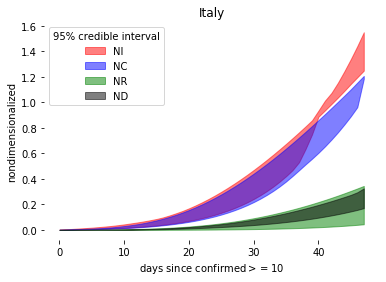

In [6]:

x = np.shape(fit['fit']['u'])[1]
NI_lb = []
NI_ub = []
NC_lb = []
NC_ub = []
NR_lb = []
NR_ub = []
ND_lb = []
ND_ub = []
for i in range(x):
    NI_lb.append(np.percentile(fit['fit']['u'][:,i,2],2.5))
    NI_ub.append(np.percentile(fit['fit']['u'][:,i,2],97.5))
    NC_lb.append(np.percentile(fit['fit']['u'][:,i,3],2.5))
    NC_ub.append(np.percentile(fit['fit']['u'][:,i,3],97.5))
    NR_lb.append(np.percentile(fit['fit']['u'][:,i,4],2.5))
    NR_ub.append(np.percentile(fit['fit']['u'][:,i,4],97.5))
    ND_lb.append(np.percentile(fit['fit']['u'][:,i,5],2.5))
    ND_ub.append(np.percentile(fit['fit']['u'][:,i,5],97.5))
    
plt.fill_between(range(x), NI_lb, NI_ub,color='r',label='NI',alpha=a)
plt.fill_between(range(x), NC_lb, NC_ub,color='b',label='NC',alpha=a)
plt.fill_between(range(x), NR_lb, NR_ub,color='g',label='NR',alpha=a)
plt.fill_between(range(x), ND_lb, ND_ub,color='k',label='ND',alpha=a)
plt.ylabel('nondimensionalized')
plt.xlabel(r'days since confirmed$>=$10')
plt.title(roi)
plt.legend(title='95% credible interval',loc=2)
simpleaxis(plt.gca())
# plt.ylim((0,0.5))